# Real NVP with distribution learning for molecular confomations

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pytraj as pt
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
%matplotlib inline

#import tensorflow.contrib.eager as tfe # For eager mode
#tfe.enable_eager_execution()

/Users/tachi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Setting for Real NVP
tf.set_random_seed(0)
sess = tf.InteractiveSession()
tfd = tf.contrib.distributions
tfb = tfd.bijectors
batch_size = 5000

DTYPE = tf.float32
NP_DTYPE = np.float32
MODEL = 'NVP' # Which Normalizing Flow to use. 'NVP' or 'MAF' or 'IAF'
USE_BATCHNORM = False


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
# Get molecular conformations from the MD data set of alanine dipeptide.
pos_list = []
for i in range(1, batch_size + 1):
    filename = '../save/md-alanine-dipeptide/outputs/dcd_convert.pdb.%d' % i
    pdb = PDBFile(filename)
    pos = pdb.getPositions(asNumpy=True) / nanometer
    pos_flatten = list(pos.flatten().astype(np.float32))
    pos_list.append(pos_flatten)
#converted_list = tf.convert_to_tensor(pos_list)

In [4]:
# Generate and sample a source distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([np.shape(pos_list)[1]], dtype=tf.float32))
base_samples = base_dist.sample(batch_size)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlo

In [5]:
# Real NVP
def net(x, out_size):
    return tf.contrib.layers.stack(x, tf.contrib.layers.fully_connected, [512, 512, out_size])

# Affine Coupling layer for Real-NVP
class NVPCoupling(tfb.Bijector):
    """NVP affine coupling layer for 2D units.
    """

    def __init__(self, D, d, layer_id=0, validate_args=False, name="NVPCoupling"):
        """
        Args:
          d: First d units are pass-thru units.
        """
        # first d numbers decide scaling/shift factor for remaining D-d numbers.
        super(NVPCoupling, self).__init__(
             forward_min_event_ndims=1, 
            validate_args=validate_args, 
            name=name
        )
        self.D, self.d = D, d
        self.id = layer_id
        # create variables here
        tmp = tf.placeholder(dtype=DTYPE, shape=[1, self.d])
        self.s(tmp)
        self.t(tmp)

    def s(self, xd):
        with tf.variable_scope('s%d' % self.id, reuse=tf.AUTO_REUSE):
            return net(xd, self.D - self.d) # Adjust the number of dimensions for the hadamard product

    def t(self, xd):
        with tf.variable_scope('t%d' % self.id, reuse=tf.AUTO_REUSE):
            return net(xd, self.D - self.d) # Adjust the number of dimensions for the hadamard product

    def _forward(self, x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        yD = xD * tf.exp(self.s(xd)) + self.t(xd)  # [batch, D-d]
        return tf.concat([xd, yD], axis=1)

    def _inverse(self, y):
        yd, yD = y[:, :self.d], y[:, self.d:]
        xD = (yD - self.t(yd)) * tf.exp(-self.s(yd))
        return tf.concat([yd, xD], axis=1)

    def _forward_log_det_jacobian(self, x):
        event_dims = tf.cast(self._forward_event_shape_tensor(x), dtype=tf.int32)
        xd = x[:, :self.d]
        return tf.reduce_sum(self.s(xd), axis=1)
    
    def _inverse_log_det_jacobian(self, y):
        return -self._forward_log_det_jacobian(y)

***
### NICE (volume preserving)
$$
\rm{Forward\ addictive\ coupling\ layer}\ \it{f_{xz}}\rm{:}\\
\mathbf{z}_{\rm 1} = \mathbf{x}_{\rm 1}\\
\mathbf{z}_{\rm 2} = \mathbf{x}_{\rm 2} + T(\mathbf{x}_{\rm 1};\theta)\\
$$
$$
\rm{Inverse\ addictive\ coupling\ layer}\ \it{f_{zx}}\rm{:}\\
\mathbf{x}_{\rm 1} = \mathbf{z}_{\rm 1}\\
\mathbf{x}_{\rm 2} = \mathbf{z}_{\rm 2} - T(\mathbf{z}_{\rm 1};\theta)\\
$$
$$
\rm{Forward\ Jacobian\ determinant}\ \it{R_{xz}}\rm{:}\ 1
$$
$$
\rm{Inverse\ Jacobian\ determinant}\ \it{R_{zx}}\rm{:}\ 1
$$
***
### Real NVP (non volume preserving)
$$
\rm{Forward\ affine\ coupling\ layer}\ \it{f_{xz}}\rm{:}\\ 
\mathbf{z}_{\rm 1} = \mathbf{x}_{\rm 1}\\
\mathbf{z}_{\rm 2} = \mathbf{x}_{\rm 2}\odot \exp(-\ S(\mathbf{x}_{\rm 1};\theta)) + T(\mathbf{x}_{\rm 1};\theta)\\
$$
$$
\rm{Inverse\ affine\ coupling\ layer}\ \it{f_{zx}}\rm{:}\\
\mathbf{x}_{\rm 1} = \mathbf{z}_{\rm 1}\\
\mathbf{x}_{\rm 2} = \mathbf{z}_{\rm 2}\odot \exp(-\ S(\mathbf{z}_{\rm 1};\theta)) - T(\mathbf{z}_{\rm 1};\theta)\\
$$
$$
\rm{Forward\ Jacobian\ determinant}\ \it{R_{xz}}\rm{:}\ 
\mathrm{e}^{\sum_{\it i} S(\mathbf{x}_{1};\theta)_{\it i}}
$$
$$
\rm{Inverse\ Jacobian\ determinant}\ \it{R_{zx}}\rm{:}\ 
\mathrm{e}^{-\sum_{\it i}S(\mathbf{z}_{1};\theta)_{\it i}}
$$
***

In [6]:
# BatchNorm Bijector
class BatchNorm(tfb.Bijector):
    def __init__(self, eps=1e-5, decay=0.95, validate_args=False, name="batch_norm"):
        super(BatchNorm, self).__init__(
             forward_min_event_ndims=1, validate_args=validate_args, name=name)
        self._vars_created = False
        self.eps = eps
        self.decay = decay

    def _create_vars(self, x):
        n = x.get_shape().as_list()[1]
        with tf.variable_scope(self.name):
            self.beta = tf.get_variable('beta', [1, n], dtype=DTYPE)
            self.gamma = tf.get_variable('gamma', [1, n], dtype=DTYPE)
            self.train_m = tf.get_variable('mean', [1, n], dtype=DTYPE, trainable=False)
            self.train_v = tf.get_variable('var', [1, n], dtype=DTYPE, 
                initializer=tf.ones_initializer, trainable=False)
        self._vars_created = True

    def _forward(self, u):
        if not self._vars_created:
            self._create_vars(u)
        return (u - self.beta) * tf.exp(-self.gamma) * tf.sqrt(self.train_v + self.eps) + self.train_m

    def _inverse(self, x):
        # Eq 22. Called during training of a normalizing flow.
        if not self._vars_created:
            self._create_vars(x)
        # statistics of current minibatch
        m, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        # update train statistics via exponential moving average
        update_train_m = tf.assign_sub(
            self.train_m, self.decay * (self.train_m - m))
        update_train_v = tf.assign_sub(
            self.train_v, self.decay * (self.train_v - v))
        # normalize using current minibatch statistics, followed by BN scale and shift
        with tf.control_dependencies([update_train_m, update_train_v]):
            return (x - m) * 1. / tf.sqrt(v + self.eps) * tf.exp(self.gamma) + self.beta

    def _inverse_log_det_jacobian(self, x):
        # at training time, the log_det_jacobian is computed from statistics of the
        # current minibatch.
        if not self._vars_created:
            self._create_vars(x)
        _, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        abs_log_det_J_inv = tf.reduce_sum(self.gamma - .5 * tf.log(v + self.eps))
        return abs_log_det_J_inv

In [7]:
# Construct the flow
bijectors = []
num_layers = 2
nd = np.shape(pos_list)[1]
sepdim = int(nd / 2)
perm_list = list(reversed([i for i in range(0, nd)]))

for i in range(num_layers):
    if MODEL == 'NVP':
        bijectors.append(NVPCoupling(D=nd, d=sepdim, layer_id=i))
    elif MODEL == 'MAF':
        bijectors.append(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512])))
    elif MODEL == 'IAF':
        bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512]))))
    if USE_BATCHNORM and i % 2 == 0:
        # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
        bijectors.append(BatchNorm(name='batch_norm%d' % i))
    bijectors.append(tfb.Permute(permutation=perm_list))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


In [8]:
# Visualize the flow (before optimization)
x = base_dist.sample(batch_size)
samples = [x]
names = [base_dist.name]

for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [9]:
sess.run(tf.global_variables_initializer())

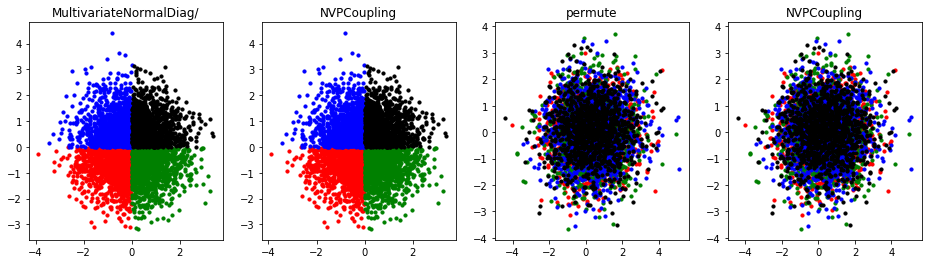

In [10]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

In [11]:
# Optimize the flow
import random
num_epochs = int(10)
minibatch_size = int(50)
ep_step = []
ep_losses = []
minibatch = tf.placeholder(tf.float32, shape=[minibatch_size, np.shape(pos_list)[1]])
loss = -tf.reduce_mean(dist.log_prob(minibatch))
with tf.variable_scope('Adam', reuse=tf.AUTO_REUSE):
    train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
sess.run(tf.global_variables_initializer())

for ep in range(0, num_epochs): # Minibatch learning
    suffule_list = random.sample(pos_list, len(pos_list))
    for idx in range(0, batch_size, minibatch_size):
        _, np_loss = sess.run([train_op,  loss], feed_dict={minibatch: suffule_list[idx:idx+minibatch_size]})
    if ep % 1 == 0:
        ep_step.append(i)
        ep_losses.append(np_loss)  
    if ep % 1 == 0:
        print(ep, np_loss)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
Use tf.cast instead.
0 61.739872
1 61.747456
2 61.73766
3 61.737038
4 61.731846
5 61.73662
6 61.737064
7 61.731888
8 61.73104
9 61.735363


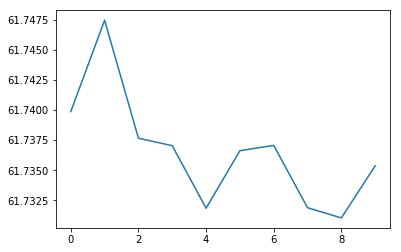

In [12]:
# Plot the loss function
start = 0
plt.plot(ep_losses[start:])

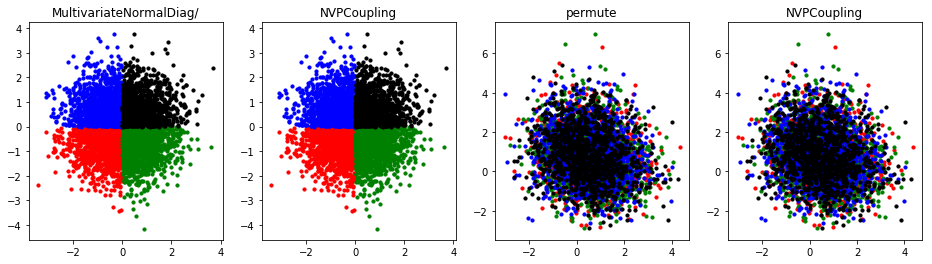

In [13]:
# Visualize the normalizing flow
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

<IPython.core.display.Javascript object>


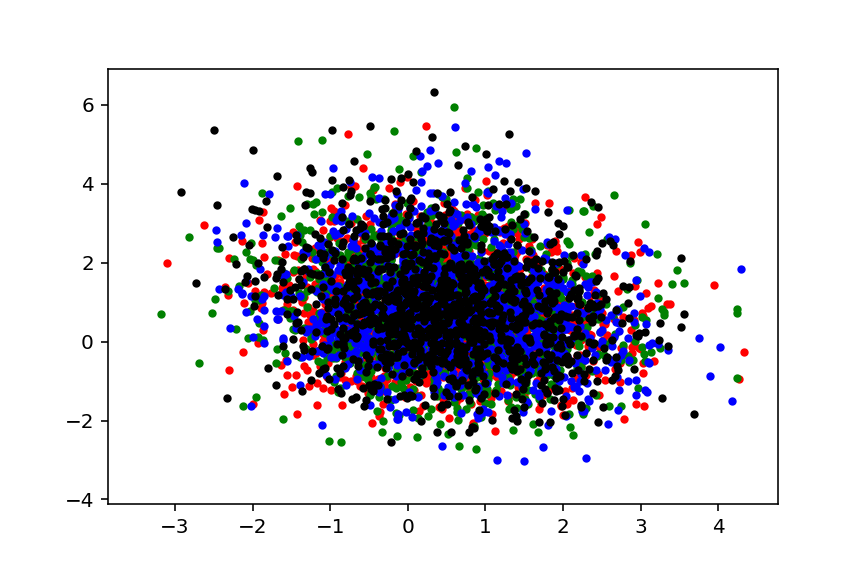

In [15]:
# Animation
%matplotlib nbagg
# We can only use this magic comment on Jupyter Notebook so far (15/07/2019).
import matplotlib.animation as animation
results = sess.run(samples)
X0 = results[0]
images = []
fig = plt.figure()

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    image1 = plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    image2 = plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    image3 = plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    image4 = plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    images.append([image1] +[image2] +[image3] + [image4])
    
ani = animation.ArtistAnimation(fig, images, interval=1000)
ani.save('anim.gif', writer="imagemagick")
plt.show()

In [20]:
# Understanding the flow by Tensorboard
summary_writer = tf.summary.FileWriter('data', graph=sess.graph)
tf.summary.scalar('summary', samples)

<tf.Tensor 'summary:0' shape=() dtype=string>

In [21]:
# Visualize the flow (Generation)
test = base_dist.sample(1000)
test_samples = [test]
test_names = [base_dist.name]

for bijector in reversed(dist.bijector.bijectors):
    test = bijector.forward(test)
    test_samples.append(test)
    test_names.append(bijector.name)

<IPython.core.display.Javascript object>


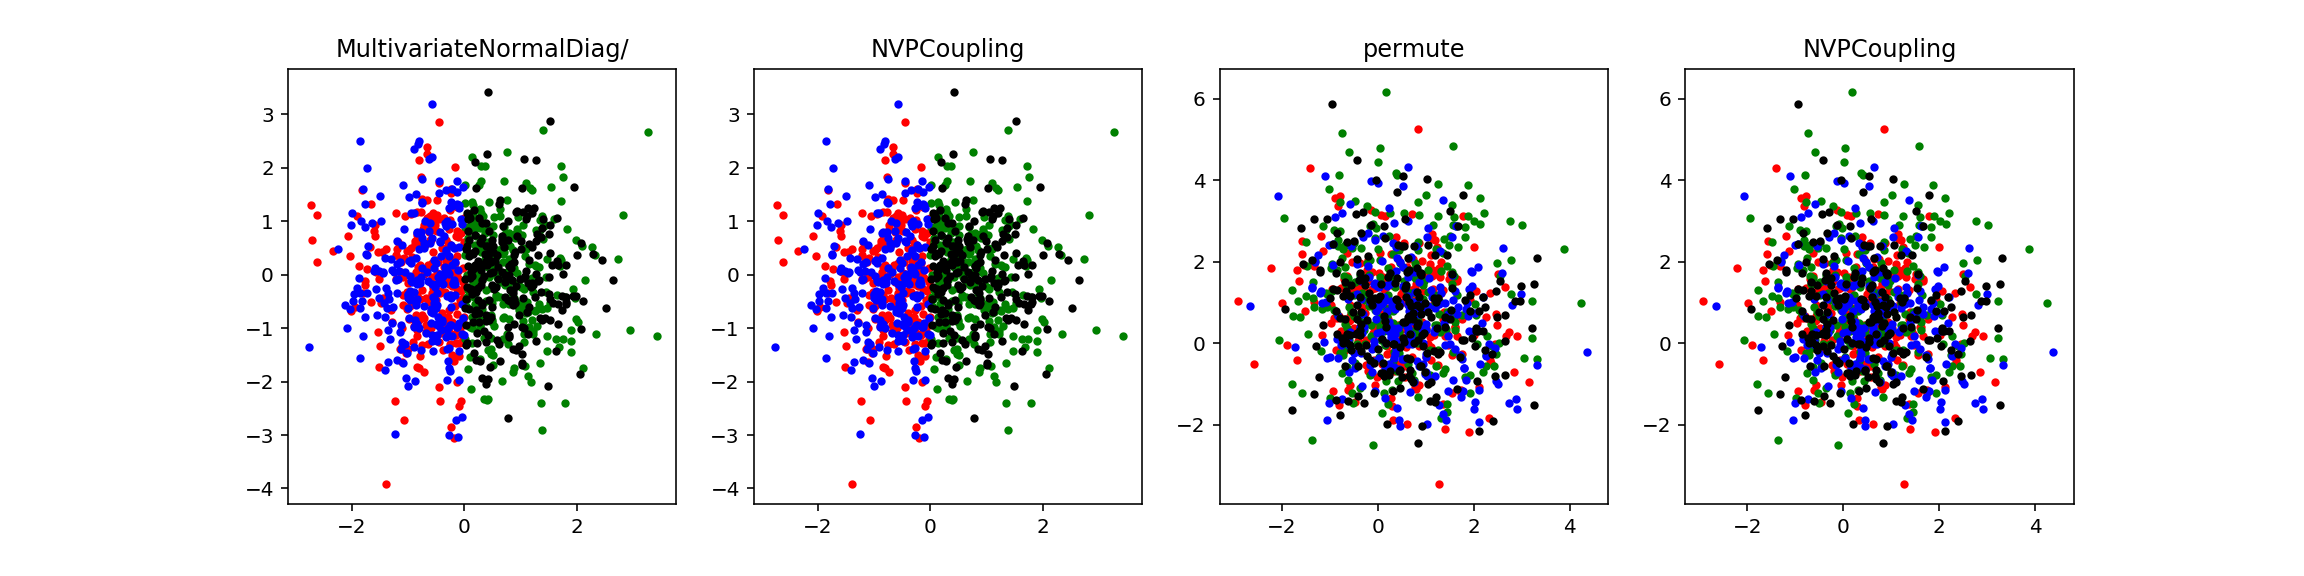

In [22]:
results = sess.run(test_samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 2] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 2] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 2] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 2] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    #arr[i].set_xlim([-2, 2])
    #arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

In [19]:
# Write the samples generated from real NVP
temp = 310
delta = 0.002

prmtop = AmberPrmtopFile('/Users/tachi/Development/md-alanine-dipeptide/inputs/adip.prmtop')
inpcrd = AmberInpcrdFile('/Users/tachi/Development/md-alanine-dipeptide/inputs/adip.inpcrd')
system = prmtop.createSystem(implicitSolvent=GBn, nonbondedCutoff=1 * nanometer,
        constraints=HBonds)
integrator = LangevinIntegrator(temp * kelvin, 1 / picosecond, delta * picoseconds)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

In [23]:
for i,pos in enumerate(results[0]):
    filename = 'outputs/test_gen.pdb.%d' % i
    with open(filename,'w') as f:
        PDBFile.writeFile(topology=prmtop.topology, positions=pos.reshape(22,3) * nanometer, file=f)

In [24]:
#  Calculate potential energies from each frame
pe_list = []
unit = kilojoule / mole
for i in range(1, len(results[0])):
    filename = 'outputs/test_gen.pdb.%d' % i
    pdb = PDBFile(filename)
    simulation.context.setPositions(pdb.getPositions())
    state = simulation.context.getState(getEnergy=True)
    pe_list.append(state.getPotentialEnergy() / unit)
    print(i, state.getPotentialEnergy())

1 5775499.5 kJ/mol
2 10024537.0 kJ/mol
3 12126362.0 kJ/mol
4 6493451.0 kJ/mol
5 8599617.0 kJ/mol
6 4611229.0 kJ/mol
7 7393263.5 kJ/mol
8 12788626.0 kJ/mol
9 11251532.0 kJ/mol
10 10195273.0 kJ/mol
11 6330550.0 kJ/mol
12 5129535.5 kJ/mol
13 3328413.25 kJ/mol
14 5989378.0 kJ/mol
15 9583643.0 kJ/mol
16 7286176.0 kJ/mol
17 8286782.0 kJ/mol
18 6200501.0 kJ/mol
19 17748814.0 kJ/mol
20 6346449.5 kJ/mol
21 13171306.0 kJ/mol
22 9566247.0 kJ/mol
23 8899003.0 kJ/mol
24 7137879.5 kJ/mol
25 6005265.5 kJ/mol
26 6487706.5 kJ/mol
27 9077525.0 kJ/mol
28 12805000.0 kJ/mol
29 11970126.0 kJ/mol
30 3596137.25 kJ/mol
31 8760423.0 kJ/mol
32 14322296.0 kJ/mol
33 8350233.5 kJ/mol
34 8542146.0 kJ/mol
35 5542397.0 kJ/mol
36 8524273.0 kJ/mol
37 5678849.0 kJ/mol
38 9517444.0 kJ/mol
39 3379798.0 kJ/mol
40 11490113.0 kJ/mol
41 6521692.0 kJ/mol
42 6674714.0 kJ/mol
43 4131371.25 kJ/mol
44 11637949.0 kJ/mol
45 7781715.0 kJ/mol
46 17093680.0 kJ/mol
47 3281426.25 kJ/mol
48 7806706.0 kJ/mol
49 9155215.0 kJ/mol
50 9395759.0

418 7853069.5 kJ/mol
419 13473418.0 kJ/mol
420 6737363.0 kJ/mol
421 7927945.5 kJ/mol
422 7748436.5 kJ/mol
423 5651679.5 kJ/mol
424 5452006.5 kJ/mol
425 5597258.5 kJ/mol
426 7722054.0 kJ/mol
427 8575969.0 kJ/mol
428 14274160.0 kJ/mol
429 7525085.0 kJ/mol
430 5246724.0 kJ/mol
431 5834691.5 kJ/mol
432 7907944.0 kJ/mol
433 11056216.0 kJ/mol
434 12435285.0 kJ/mol
435 37883100.0 kJ/mol
436 10624903.0 kJ/mol
437 6810761.5 kJ/mol
438 11768205.0 kJ/mol
439 8873837.0 kJ/mol
440 6074344.0 kJ/mol
441 15641933.0 kJ/mol
442 8784535.0 kJ/mol
443 4768390.5 kJ/mol
444 13720988.0 kJ/mol
445 12313408.0 kJ/mol
446 5048569.5 kJ/mol
447 9015038.0 kJ/mol
448 10925490.0 kJ/mol
449 13057404.0 kJ/mol
450 8083908.5 kJ/mol
451 5065264.0 kJ/mol
452 8655026.0 kJ/mol
453 12986867.0 kJ/mol
454 4903327.0 kJ/mol
455 5433222.5 kJ/mol
456 6402689.5 kJ/mol
457 9088441.0 kJ/mol
458 3507542.75 kJ/mol
459 3974554.25 kJ/mol
460 8498120.0 kJ/mol
461 12124358.0 kJ/mol
462 9189423.0 kJ/mol
463 7117112.0 kJ/mol
464 8051311.5 kJ/m

835 6819237.0 kJ/mol
836 13837648.0 kJ/mol
837 11206756.0 kJ/mol
838 15300395.0 kJ/mol
839 6603395.5 kJ/mol
840 12144385.0 kJ/mol
841 4740293.5 kJ/mol
842 7774306.5 kJ/mol
843 7545652.0 kJ/mol
844 10163244.0 kJ/mol
845 13191377.0 kJ/mol
846 7410313.5 kJ/mol
847 15271521.0 kJ/mol
848 9267959.0 kJ/mol
849 7035188.0 kJ/mol
850 7665382.5 kJ/mol
851 9763469.0 kJ/mol
852 9142251.0 kJ/mol
853 5875310.5 kJ/mol
854 10375548.0 kJ/mol
855 14897370.0 kJ/mol
856 10455427.0 kJ/mol
857 13590420.0 kJ/mol
858 3690830.25 kJ/mol
859 9706751.0 kJ/mol
860 5561124.5 kJ/mol
861 9337742.0 kJ/mol
862 6066630.0 kJ/mol
863 7787005.0 kJ/mol
864 8189953.0 kJ/mol
865 7283709.0 kJ/mol
866 8716134.0 kJ/mol
867 10052764.0 kJ/mol
868 9191204.0 kJ/mol
869 11698027.0 kJ/mol
870 8668514.0 kJ/mol
871 6603625.0 kJ/mol
872 8042944.0 kJ/mol
873 17210748.0 kJ/mol
874 14510404.0 kJ/mol
875 5239696.5 kJ/mol
876 16689652.0 kJ/mol
877 7651602.0 kJ/mol
878 11006934.0 kJ/mol
879 9316710.0 kJ/mol
880 14111697.0 kJ/mol
881 6958951.0 k

Text(0.5,0,'Potential energy (kJ/mol)')

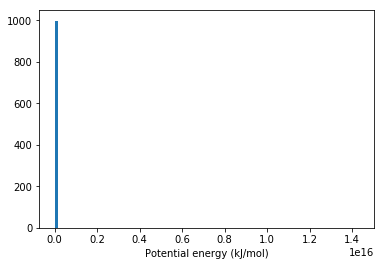

In [27]:
# Histgram
%matplotlib inline
plt.hist(pe_list, bins=100)
plt.xlabel('Potential energy (kJ/mol)')